# Cell motility study

In this notebook we will go through how we can use PhysiCOOL to test the effect of the cell motility parameters on the cells' trajectories and migration patterns. We will start by creating a simple black box model to run the simulation through Python and then adding other components to extend its functionalities.

## Creating the initial cell positions .csv file

We want to study the effect of migration parameters (namely the **speed** and **migration_bias**). Our PhysiCell model considers cells that are attracted to oxygen and there is an oxygen gradient from `y_max` to `y_min`. Thus, we will place the cells close to the `y_min` wall to then evaluate how much they migrated towards the opposite wall.

In [1]:
import numpy as np

# Creates an array with the cell coordinates and saves it to a csv file.
# Cells will be placed in a line (y=-450), in the same z-plane (z=0).
cell_definition = 0
z_plane = 0
y_coordinate = -450
x_min = -450
x_max = 450
x_spacing = 100

coords = np.asarray([[x, y_coordinate, z_plane, cell_definition] 
                     for x in np.arange(x_min, x_max+1, x_spacing)])
                     
np.savetxt("config/cells.csv", coords, delimiter=",")

## Setting up the environment

We can use PhysiCOOL to compile our project with a Python command and create a black box that can be used to run the PhysiCell model (we must be in the same directory as the simulation files).

In [1]:
from physicool import optimization as opt

# Compiles the project and creates a black box object for it
opt.compile_project()    
black_box = opt.PhysiCellBlackBox()

## Running the model

Running a model with the black box is quite easy: we just have to call the `run()` method. Furthermore, we can choose the number of replicates to be run and whether the output data should be saved (it will be stored in a new folder called `temp`).

In [2]:
opt.clean_tmp_files()
black_box.run(number_of_replicates=1, keep_files=True)

## Plotting the results

PhysiCOOL offers functions to extract and plot the cell trajectories both in 3D and 2D.

<Axes3DSubplot:>

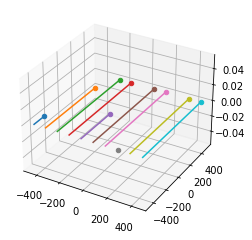

In [3]:
%matplotlib inline
from physicool.processing import get_cell_trajectories
from physicool.plotting import plot_trajectories_3d, plot_trajectories_2d

trajectories = get_cell_trajectories("temp", version="1.9.1")
plot_trajectories_3d(trajectories)

## Adding a params updater to the black box

We can add a `ParamsUpdater` instance to our black box to update the XML file with new parameter values before the simulation is run.

In [4]:
from physicool.updaters import CellUpdater, update_motility_values

# Define the updater we want to use (change motility data)
new_values = {"speed": 5.0, "migration_bias": 1.0}
updater = CellUpdater(updater_function=update_motility_values,
                     config_path="config/PhysiCell_settings.xml", cell_definition_name="default")

# Assign the updater to the black box
black_box.updater = updater

# Run the model with the new values
opt.clean_tmp_files()
black_box.run(params=new_values)

<Axes3DSubplot:>

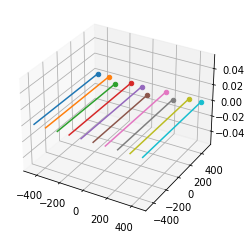

In [5]:
# Plot the trajectories
trajectories = get_cell_trajectories("temp", version="1.9.1")
plot_trajectories_3d(trajectories)

## Adding a processing routine to extract the final positions

We can also add a `OutputProcessor` instance to extract and quantify data from our output files. In this case, we are interested in getting the y coordinates for the last time point, to assess how close the cells are at the end of the simulation to the `y_max` wall (oxygen source).

In [6]:
from physicool.processing import get_final_y_position

opt.clean_tmp_files()
black_box.processor = get_final_y_position
black_box.version = "1.9.1"
final_positions = black_box.run(new_values)

print("\n\n Cell final positions:")
print(final_positions)



 Cell final positions:
[492.39196666 492.35722033 492.21000887 492.39196666 493.46842872
 493.46842872 493.46842872 493.46842872 183.25       183.25      ]
